In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib

In [ ]:
# Cấu hình
pd.set_option('display.max_columns', None)
TIME_STEPS = 14  # Dùng 14 ngày quá khứ để dự báo ngày mai

In [ ]:
# ==========================================
# PHẦN 1: XỬ LÝ DỮ LIỆU QUY MÔ LỚN (FULL DATASET)
# ==========================================
print("--- [1/6] Đang tải và xử lý dữ liệu từ toàn bộ 49 địa điểm... ---")

# 1. Load Data
df = pd.read_csv('weatherAUS.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.dropna(subset=['RainTomorrow'], inplace=True) # Bỏ dòng không có nhãn

# 2. Chọn Features
# Model sẽ học quy luật vật lý chung, không phụ thuộc tên địa điểm cụ thể
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
            'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']

data_subset = df[features + ['RainTomorrow', 'Location', 'Date']].copy()

# 3. Điền dữ liệu thiếu (Imputation) & Encoding
# Tách cột số và cột chữ
num_cols = [c for c in features if data_subset[c].dtype in ['float64', 'int64']]
cat_cols = [c for c in features if data_subset[c].dtype == 'object']

# Điền missing value
imputer_num = SimpleImputer(strategy='mean')
data_subset[num_cols] = imputer_num.fit_transform(data_subset[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
data_subset[cat_cols] = imputer_cat.fit_transform(data_subset[cat_cols])

# Encode Binary (RainToday, RainTomorrow)
le = LabelEncoder()
data_subset['RainToday'] = le.fit_transform(data_subset['RainToday'])
data_subset['RainTomorrow'] = le.fit_transform(data_subset['RainTomorrow'])

# 4. Scaling (Chuẩn hóa về 0-1)
scaler = MinMaxScaler()
feature_data = data_subset[features].values
feature_data_scaled = scaler.fit_transform(feature_data)

# Gán ngược lại để chuẩn bị cắt chuỗi
df_processed = pd.DataFrame(feature_data_scaled, columns=features)
df_processed['RainTomorrow'] = data_subset['RainTomorrow'].values
df_processed['Location'] = data_subset['Location'].values
df_processed['Date'] = data_subset['Date'].values

--- [1/6] Đang tải và xử lý dữ liệu từ toàn bộ 49 địa điểm... ---


In [ ]:
# ==========================================
# PHẦN 2: TẠO CHUỖI THỜI GIAN (STACKING SEQUENCES)
# ==========================================
print("--- [2/6] Đang tạo Sliding Window cho từng thành phố... ---")

def create_dataset_by_location(dataset, time_steps=14):
    X_list, y_list = [], []

    # Nhóm theo địa điểm để đảm bảo tính liên tục của thời gian
    grouped = dataset.groupby('Location')

    for name, group in grouped:
        # Sắp xếp theo ngày trong từng thành phố
        group = group.sort_values('Date')

        # Lấy data (chỉ lấy chỉ số khí tượng, bỏ Location/Date)
        data_values = group[features].values
        target_values = group['RainTomorrow'].values

        # Tạo cửa sổ trượt
        for i in range(len(data_values) - time_steps):
            X_list.append(data_values[i:(i + time_steps)])
            y_list.append(target_values[i + time_steps])

    return np.array(X_list), np.array(y_list)

X_full, y_full = create_dataset_by_location(df_processed, TIME_STEPS)
print(f"Kích thước dữ liệu tổng hợp: {X_full.shape} (Samples, TimeSteps, Features)")

# Chia Train/Test (Shuffle=True ok vì các mẫu là chuỗi độc lập từ nhiều TP)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Tính Class Weight (Để xử lý mất cân bằng dữ liệu cho LSTM/CNN)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights (0: No, 1: Yes): {class_weight_dict}")

--- [2/6] Đang tạo Sliding Window cho từng thành phố... ---
Kích thước dữ liệu tổng hợp: (141507, 14, 13) (Samples, TimeSteps, Features)
Train size: 113205, Test size: 28302
Class Weights (0: No, 1: Yes): {0: np.float64(0.6444698729334608), 1: np.float64(2.2304645939236316)}


In [ ]:
# ==========================================
# PHẦN 3: MODEL 1 - LOGISTIC REGRESSION (BASELINE)
# ==========================================
print("\n--- [3/6] Training Logistic Regression (Baseline)... ---")

# Logistic Regression cần input 2D. Ta làm phẳng (Flatten) chuỗi thời gian
# Ví dụ: 14 ngày * 13 features = 182 features đầu vào
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_logreg = LogisticRegression(solver='liblinear', random_state=42)
model_logreg.fit(X_train_flat, y_train)
print("Logistic Regression Training Done.")


--- [3/6] Training Logistic Regression (Baseline)... ---
Logistic Regression Training Done.


In [ ]:
# ==========================================
# PHẦN 4: MODEL 2 - BIDIRECTIONAL LSTM (MAIN MODEL)
# ==========================================
print("\n--- [4/6] Training Bidirectional LSTM (Main)... ---")

model_lstm = Sequential()
# Bidirectional giúp học cả quá khứ và tương lai trong chuỗi
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True),
                             input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(32, return_sequences=False))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train với Class Weight
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=20, # Có thể tăng lên 30-50 nếu máy khỏe
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight_dict, # <--- QUAN TRỌNG
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)


--- [4/6] Training Bidirectional LSTM (Main)... ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - accuracy: 0.5894 - loss: 0.6620 - val_accuracy: 0.6527 - val_loss: 0.6233
Epoch 2/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.6299 - loss: 0.6410 - val_accuracy: 0.6278 - val_loss: 0.6510
Epoch 3/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.6437 - loss: 0.6299 - val_accuracy: 0.6605 - val_loss: 0.6107
Epoch 4/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.6411 - loss: 0.6252 - val_accuracy: 0.6851 - val_loss: 0.5827
Epoch 5/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.6369 - loss: 0.6288 - val_accuracy: 0.6827 - val_loss: 0.5876
Epoch 6/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - accuracy: 0.6385 - loss: 0.6234 - val_accuracy: 0.6560 - val_loss: 0.6132
Epoch 7/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.6411 - loss: 0.6233 - val_accuracy: 0.5952 - val_loss: 0.6593
Epoch 8/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.6487 -

In [ ]:
# ==========================================
# PHẦN 5: MODEL 3 - 1D-CNN / TCN (COMPARATIVE MODEL)
# ==========================================
print("\n--- [5/6] Training 1D-CNN (Comparison)... ---")

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)
print("CNN Training Done.")


--- [5/6] Training 1D-CNN (Comparison)... ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Training Done.



--- [6/6] Tổng hợp kết quả so sánh ---

BẢNG KẾT QUẢ HIỆU NĂNG:
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.7763     0.5168  0.1130    0.1855
1   Bidirectional LSTM    0.6852     0.3738  0.5880    0.4570
2         1D-CNN (TCN)    0.6797     0.3675  0.5844    0.4512


/tmp/ipython-input-720704263.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=results_df, palette='viridis')


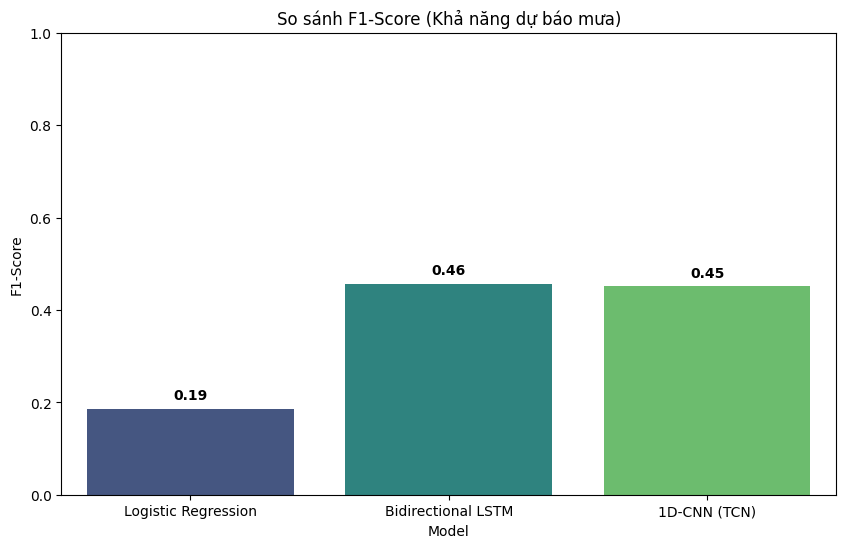

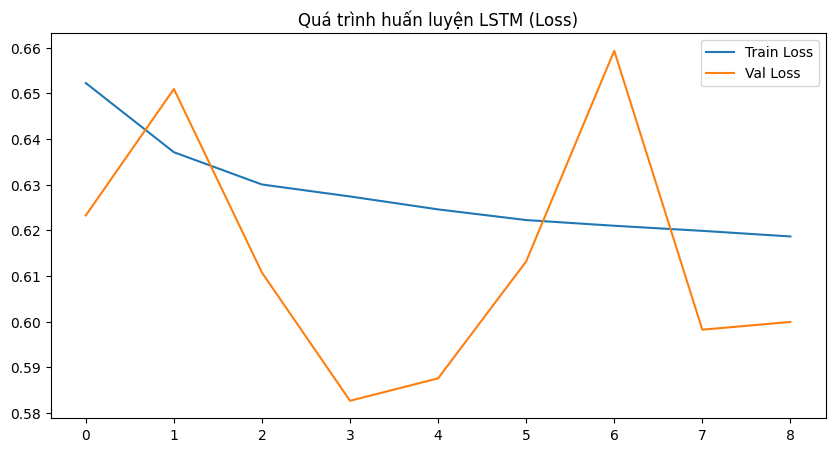


HOÀN THÀNH! Bạn hãy dùng bảng kết quả và biểu đồ trên để đưa vào báo cáo.


In [ ]:
# ==========================================
# PHẦN 6: ĐÁNH GIÁ & SO SÁNH (EVALUATION)
# ==========================================
print("\n--- [6/6] Tổng hợp kết quả so sánh ---")

# 1. Dự báo
y_pred_logreg = model_logreg.predict(X_test_flat)

y_pred_lstm_prob = model_lstm.predict(X_test, verbose=0)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype("int32").flatten()

y_pred_cnn_prob = model_cnn.predict(X_test, verbose=0)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype("int32").flatten()

# 2. Tính Metrics
models = ['Logistic Regression', 'Bidirectional LSTM', '1D-CNN (TCN)']
preds = [y_pred_logreg, y_pred_lstm, y_pred_cnn]
results = []

for name, p in zip(models, preds):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, p),
        'Precision': precision_score(y_test, p),
        'Recall': recall_score(y_test, p),
        'F1-Score': f1_score(y_test, p)
    })

results_df = pd.DataFrame(results)

# 3. Hiển thị bảng kết quả
print("\nBẢNG KẾT QUẢ HIỆU NĂNG:")
print(results_df.round(4))

# 4. Vẽ biểu đồ so sánh F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=results_df, palette='viridis')
plt.title('So sánh F1-Score (Khả năng dự báo mưa)')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df['F1-Score']):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')
plt.show()

# 5. Vẽ Loss của LSTM để check Overfitting
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Quá trình huấn luyện LSTM (Loss)')
plt.legend()
plt.show()

print("\nHOÀN THÀNH! Bạn hãy dùng bảng kết quả và biểu đồ trên để đưa vào báo cáo.")

In [ ]:
import joblib

# 1. Lưu model LSTM (định dạng Keras)
model_lstm.save('lstm_weather_model.h5')

# 2. Lưu bộ chuẩn hóa Scaler (RẤT QUAN TRỌNG)
# Nếu không có cái này, số liệu nhập từ web (ví dụ 30 độ C) sẽ không khớp với số liệu lúc train (0.5)
joblib.dump(scaler, 'scaler.pkl')

print("Đã lưu xong: lstm_weather_model.h5 và scaler.pkl")

Đã lưu xong: lstm_weather_model.h5 và scaler.pkl
